In [134]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
print("PyTorch version:", torch.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)

#%matplotlib nbagg
#plt.interactive(False)

PyTorch version: 1.13.0+cu117
Numpy version: 1.23.5
Matplotlib version: 3.6.2


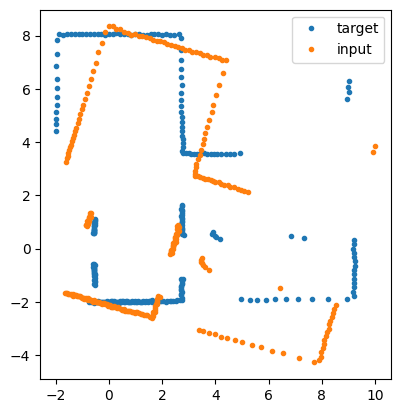

In [135]:
angle_min = -2.35619449615
angle_max = 2.35619449615
angle_increment = 0.0174532923847
range_max = 15.0
ranges1 = np.load("laserdata1.npy")
ranges2 = np.load("laserdata2.npy")

x1 = ranges1 * np.cos(np.arange(angle_min, angle_max, angle_increment))
y1 = ranges1 * np.sin(np.arange(angle_min, angle_max, angle_increment))
pc1 = np.stack([x1,y1])

x2 = ranges2 * np.cos(np.arange(angle_min, angle_max, angle_increment))
y2 = ranges2 * np.sin(np.arange(angle_min, angle_max, angle_increment))
pc2 = np.stack([x2,y2])

_=plt.plot(pc1[0], pc1[1], '.')
_=plt.plot(pc2[0], pc2[1], '.')
_=plt.legend(["target", "input"])
_=plt.gca().set_aspect('equal')

In [140]:
n = pc1.shape[1]

def f(R, T):
    pc1_t = torch.tensor(pc1).float()
    pc2_t = torch.tensor(pc2).float()
    pc2_t_RT = R @ pc2_t + T.reshape(-1, 1)
    x_diff = pc1_t[0,:].reshape(-1,1) - pc2_t_RT[0,:].reshape(1,-1)
    y_diff = pc1_t[1,:].reshape(-1,1) - pc2_t_RT[1,:].reshape(1,-1)
    residuals = torch.exp(-(x_diff**2+y_diff**2)/0.01)
    return -torch.sum(residuals**2)

In [141]:
r = torch.tensor(0.0, requires_grad=True)
T = torch.tensor([0., 0.], requires_grad=True)
params = [r, T]

optimizer = torch.optim.LBFGS(params, lr=1, max_iter=1, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn="strong_wolfe")
#optimizer = torch.optim.Rprop(params, lr=0.01, etas=(0.1, 1.1), step_sizes=(0.00001, 50))
#optimizer =torch.optim.SGD(params, lr=0.0001, momentum=0.1, dampening=0, weight_decay=0, nesterov=False)
#optimizer = torch.optim.Adam(params, lr=0.1, betas=(0.8, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
xdata, ydata = [], []
p1, = plt.plot(pc1[0, :], pc1[1, :], ".")
p2, = plt.plot([], [], ".")

def init():
    return p1, p2,

def closure():
    optimizer.zero_grad()
    R = torch.stack([torch.cos(r), -torch.sin(r), torch.sin(r), torch.cos(r)]).reshape((2,2))
    loss = f(R, T)
    loss.backward()
    return loss

def update(frame):
    optimizer.zero_grad()
    R = torch.stack([torch.cos(r), -torch.sin(r), torch.sin(r), torch.cos(r)]).reshape((2,2))
    loss = f(R, T)
    loss.backward()
    optimizer.step(closure)
    pc2_plot = (R.detach().numpy() @ pc2 + T.reshape(-1, 1).detach().numpy())
    p2.set_data(pc2_plot[0, :], pc2_plot[1, :])
    return p1, p2,

ani = FuncAnimation(fig, update, frames=50,
                    init_func=init, blit=True)

plt.close()

HTML(ani.to_html5_video())